<a href="https://colab.research.google.com/github/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

```yaml
Generator:
  - Input: 100 (90 noise, 10 one-hot)
  - h1: 150
  - h2: 400
  - h3: 784

FeatureExtractor:
  - Input: 784 (28x28)
  - h1: 400
  - h2: 150
  - h3: 100

Discriminator:
  - Input: 100
  - h1: 50
  - h2: 1

Classifier:
  - Input: 100
  - h1: 50
  - h2: 10
```

Link to file: https://github.com/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/colab.ipynb

In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
data_path = "./data/mnist/"

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=True, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=False, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


In [0]:
x_train = []
x_test = []
y_test = []
y_train = []

In [0]:
def to_one_hot(x):
    b = np.zeros((x.size, 10))
    b[np.arange(x.size), x] = 1
    return b

In [0]:
for data in test_loader:
    y_test_i = data[1].numpy()
    x_test_i = data[0].numpy()
    
    x_test_i = x_test_i.reshape((28, 28))
    y_test_i = y_test_i[0]
    
    x_test.append(x_test_i)
    y_test.append(y_test_i)

In [0]:
y_test = torch.Tensor(to_one_hot(np.array(y_test)))
x_test = torch.Tensor(x_test).reshape((-1, 784))

In [0]:
for data in train_loader:
    y_test_i = data[1].numpy()
    x_test_i = data[0].numpy()
    
    x_test_i = x_test_i.reshape((28, 28))
    y_test_i = y_test_i[0]
    
    x_train.append(x_test_i)
    y_train.append(y_test_i)

y_train = torch.Tensor(to_one_hot(np.array(y_train)))
x_train = torch.Tensor(x_train).reshape((-1, 784))

In [0]:
x_train = x_train[:5000]
x_test = x_test[:500]
y_train = y_train[:5000]
y_test = y_test[:500]

In [35]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train.shape)
print(y_train.shape)

print(torch.min(x_test))
print(torch.max(x_test))
print(y_train[0])

torch.Size([5000, 784]) torch.Size([500, 784]) torch.Size([5000, 10]) torch.Size([500, 10])
torch.Size([5000, 784])
torch.Size([5000, 10])
tensor(0.)
tensor(1.)
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


In [0]:
def plot_image(x):
    plt.imshow(x, cmap='gray')
    # plt.show()

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


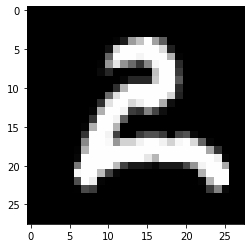

In [20]:
index = 12
plot_image(x_test[index].numpy().reshape((28, 28)))
print(y_test[index])
plt.show()

In [0]:
def get_random(shape, min_=-0.5, max_=0.5):
    return torch.FloatTensor(*shape).uniform_(min_, max_).requires_grad_()

In [0]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((100, 150)), torch.zeros(150, requires_grad=True)
        self.w2, self.b2 = get_random((150, 400)), torch.zeros(400, requires_grad=True)
        self.w3, self.b3 = get_random((400, 784)), torch.zeros(784, requires_grad=True)
    
    def forward(self, x, **kwargs):
        # x.shape = (batch, 100)
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.sigmoid(h1.matmul(self.w2) + self.b2)
        h3 = torch.sigmoid(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()
        
    def zero_grad(self):
        self.w1.grad = torch.zeros(self.w1.grad.shape)
        self.w2.grad = torch.zeros(self.w2.grad.shape)
        self.w3.grad = torch.zeros(self.w3.grad.shape)
        
        self.b1.grad = torch.zeros(self.b1.grad.shape)
        self.b2.grad = torch.zeros(self.b2.grad.shape)
        self.b3.grad = torch.zeros(self.b3.grad.shape)

    @staticmethod
    def getGeneratorInput(y, batch_size):
        gen_input = np.random.uniform(0, 1, (batch_size, 100))
        for batch in range(batch_size):
            for i in range(0, 90, 20):
                gen_input[batch][i: i+10] = y[batch]
        return torch.Tensor(gen_input)

In [54]:
print(y_test[0])
Generator.getGeneratorInput(y_test[0], 2)

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
[[0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.63059537 0.72126981
  0.89304424 0.7947097  0.40433033 0.71623552 0.09090192 0.5597902
  0.27243053 0.9394228  0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  0.00498172 0.1949677  0.23258074 0.18721035 0.43928764 0.89727629
  0.2904651  0.42833202 0.51790735 0.66943394 0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.90042814 0.75742623 0.84006409 0.45353502
  0.96976008 0.27256666 0.36913744 0.80729164 0.95835437 0.81225245
  0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.16773025 0.19482518
  0.81847576 0.60060536 0.5654057  0.85459735 0.52872296 0.7533004
  0.7990423  0.0177268  0.         0.         0.         1.
  0.         0.         0.         0.         0.         

In [0]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((784, 400)), torch.zeros(400, requires_grad=True)
        self.w2, self.b2 = get_random((400, 150)), torch.zeros(150, requires_grad=True)
        self.w3, self.b3 = get_random((150, 100)), torch.zeros(100, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.sigmoid(h1.matmul(self.w2) + self.b2)
        h3 = torch.sigmoid(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()

In [0]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((100, 50)), torch.zeros(50, requires_grad=True)
        self.w2, self.b2 = get_random((50, 1)), torch.zeros(1, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.sigmoid(h1.matmul(self.w2) + self.b2)
        return h2
    
    def optimize(self, lr):
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()

In [0]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((100, 50)), torch.zeros(50, requires_grad=True)
        self.w2, self.b2 = get_random((50, 10)), torch.zeros(10, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.nn.functional.softmax(h1.matmul(self.w2) + self.b2)
        return h2
    
    def optimize(self, lr):
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()

In [0]:
fe = FeatureExtractor()
classifier = Classifier()
discriminator = Discriminator()
generator = Generator()

In [70]:
batch_size = 20
epochs = 50

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    losses = [0, 0, 0, 0]
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
    
        
        # ------------ Train with real image ----------------
        real = torch.ones(batch_size)
        fake = torch.zeros(batch_size)
        
        features = fe(x_batch)
        discriminator_out = discriminator(features)
        classifier_out = classifier(features)
        
        loss_discriminator = torch.nn.functional.binary_cross_entropy(discriminator_out, real)
        loss_classifier = torch.nn.functional.binary_cross_entropy(classifier_out, y_batch)
        
        loss = loss_discriminator + loss_classifier
        loss.backward()
        discriminator.optimize(0.1)
        classifier.optimize(0.1)
        fe.optimize(0.1)
        
        losses[0] += float(loss)
        
        # --------------- Train with fake image -------------------

        generator_input = Generator.getGeneratorInput(y_batch, batch_size)
        
        generated = generator(generator_input)
        features = fe(generated)
        discriminator_out = discriminator(features)
        classifier_out = classifier(features)
        
        loss_discriminator = torch.nn.functional.binary_cross_entropy(discriminator_out, fake)
        loss_generator = torch.nn.functional.binary_cross_entropy(discriminator_out, real)
        loss_classifier = torch.nn.functional.binary_cross_entropy(classifier_out, y_batch)
        loss = loss_discriminator + loss_classifier
        
        loss.backward(retain_graph=True)
        
        discriminator.optimize(0.1)
        fe.optimize(0.1)
        
        generator.zero_grad()
        loss_generator.backward()
        generator.optimize(0.1)
        
        losses[1] += float(loss_discriminator)
        losses[2] += float(loss_classifier)
        losses[3] += float(loss_generator)
        
    print(f'  Losses: {losses}')

Epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])) is deprecated. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])) is deprecated. Please ensure they have the same size.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])) is deprecated. Please ensure they have the same size.


  Losses: [1.3011284405365586, 0.006751977282874577, 81.53320378065109, 2660.450089454651]
Epoch: 1
  Losses: [1.2864524333854206, 0.0075600528925861, 81.54237332940102, 2614.000144004822]
Epoch: 2
  Losses: [1.2678143054363318, 0.006126353698164166, 81.53044074773788, 2662.478260040283]
Epoch: 3
  Losses: [1.2434888042625971, 0.003505890676024137, 81.51104426383972, 2799.75075340271]
Epoch: 4
  Losses: [1.2296172274509445, 0.0035618806596176, 81.51179075241089, 2794.073173522949]
Epoch: 5
  Losses: [1.2087775887921453, 0.0025006481832861027, 81.50313022732735, 2880.794987678528]
Epoch: 6
  Losses: [1.1981545891612768, 0.004483716676077165, 81.52157124876976, 2742.4941148757935]
Epoch: 7
  Losses: [1.1873094300972298, 0.0037833360738659394, 81.52833822369576, 2778.8039226531982]
Epoch: 8
  Losses: [1.172795680759009, 0.00443135303339659, 81.51770266890526, 2750.6763801574707]
Epoch: 9
  Losses: [1.1592253188136965, 0.006441456625907449, 81.52178299427032, 2647.156991004944]
Epoch: 10
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


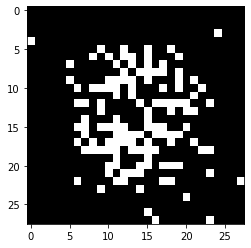

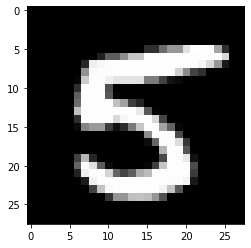

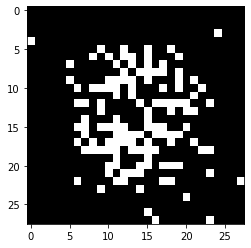

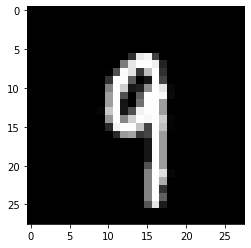

Discriminator_out fake: tensor([[5.5470e-05],
        [5.5477e-05]])
Real Img Discriminator Out: tensor([[1.0000],
        [1.0000]])

Class: tensor([[7.6277e-06, 5.3071e-07, 1.5071e-07, 8.0976e-06, 1.1732e-06, 9.9995e-01,
         5.6411e-07, 6.3524e-08, 2.9707e-05, 7.0654e-07],
        [1.1505e-06, 2.0968e-02, 3.5361e-05, 3.0092e-02, 1.2872e-02, 5.4172e-03,
         4.8659e-05, 7.6031e-04, 4.2600e-02, 8.8720e-01]])
Real class: tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


In [71]:
with torch.no_grad():
    
    index = 133
    batch_size = 2
    
    x_sample = x_test[index:index+batch_size]
    y_sample = y_test[index:index+batch_size]
    
    generator_input = Generator.getGeneratorInput(y_sample, batch_size)
        
    generated = generator(generator_input)
    features = fe(generated)
    discriminator_out = discriminator(features)
    
    features = fe(x_sample)
    real_discriminator_out = discriminator(features)
    classifier_out = classifier(features)

    
    for i in range(batch_size):
        plot_image(generated[i].reshape((28, 28)))
        plt.show()
        plot_image(x_sample[i].reshape((28, 28)))
        plt.show()
        
    
    print(f"Discriminator_out fake: {discriminator_out}\nReal Img Discriminator Out: {real_discriminator_out}")
    print(f"\nClass: {classifier_out}\nReal class: {y_sample}")

In [38]:
with torch.no_grad():
    index = 133
    x_sample = x_test[index:index+2]
    y_sample = y_test[index:index+2]
    y_pred = classifier(fe(x_sample))
    print(y_pred)
    print(y_sample)

tensor([[2.8942e-03, 1.3588e-04, 1.3840e-04, 5.9589e-03, 8.2910e-05, 9.7652e-01,
         5.8020e-06, 2.4974e-04, 1.3381e-02, 6.3833e-04],
        [2.8175e-04, 5.9488e-03, 1.7584e-04, 1.1175e-02, 2.4148e-02, 1.2686e-02,
         9.1562e-04, 6.3619e-03, 7.0668e-03, 9.3124e-01]])
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
